## Import Libraries

In [1]:
!pip install -Uqq fastbook --q --q
!pip install ipywidgets

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow 2.6.4 which is incompatible.
pandas-profiling 3.1.0 requires mar

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import imageio.v2 as imageio

sns.set_style('darkgrid')
plt.style.use('seaborn-notebook')

import fastbook
fastbook.setup_book()
import fastai

import random
random.seed(42)

from fastbook import *
from fastai.vision.all import *
import torch
from pathlib import Path
from PIL import Image

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *
import statistics

In [3]:
#make sure GPU is running
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
#Load the .csv files

#train csv
train = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')

#test csv
test = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')

In [5]:
#select all the malignant images, then downsample the benign category in remaining training data so n_malignant = n_benign for training

#split train_ims into 5 sets using StratifiedKFold from sklearn
#create a df with ALL of the malignant images
mal_ims = train[train['target']==1]
n_mal_ims = len(mal_ims)
print("Number of malignant images: {}".format(n_mal_ims))
mal_ims.head()

#create a df of a subset of benevolent images
ben_ims_subset = train[train['target']==0].sample(n=n_mal_ims, random_state=42)
n_ben_ims = len(ben_ims_subset)
print("Number of benign images in subset: {}".format(n_ben_ims))

#concatenate the two together and check the result
train_ims = pd.concat([mal_ims, ben_ims_subset])
n_training_items = len(train_ims)
print("Number of training items: {}".format(n_training_items))

#add /train prefix and /test prefix to the respective dfs
train_ims['image_name'] = 'train/' + train_ims['image_name'].astype(str)
test['image_name'] = 'test/' + test['image_name'].astype(str)

train_ims.reset_index(drop=True, inplace=True)
train_ims.head()

Number of malignant images: 584
Number of benign images in subset: 584
Number of training items: 1168


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,train/ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1
1,train/ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1
2,train/ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1
3,train/ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1
4,train/ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1


In [6]:
#split off 20% of training data as a validation set

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = train_ims['image_name'].copy()
y = train_ims['target'].copy()
fold = 0
for train_index, test_index in skf.split(X, y):
    fold+= 1
    print('In fold',fold)
    print("TRAIN LENGTH:", len(train_index), "VALIDATION LENGTH:", len(test_index))
    train_ims[f'fold_{fold}_valid']=False
    train_ims.loc[test_index,f'fold_{fold}_valid']=True
    

#Pull out 20% of entries to be held out as unseen test data for validation.
valid_ims = train_ims[train_ims['fold_5_valid'] == True]

valid_ims.reset_index(drop=True, inplace=True)
valid_ims.head()


In fold 1
TRAIN LENGTH: 934 VALIDATION LENGTH: 234
In fold 2
TRAIN LENGTH: 934 VALIDATION LENGTH: 234
In fold 3
TRAIN LENGTH: 934 VALIDATION LENGTH: 234
In fold 4
TRAIN LENGTH: 935 VALIDATION LENGTH: 233
In fold 5
TRAIN LENGTH: 935 VALIDATION LENGTH: 233


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,fold_1_valid,fold_2_valid,fold_3_valid,fold_4_valid,fold_5_valid
0,train/ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1,False,False,False,False,True
1,train/ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1,False,False,False,False,True
2,train/ISIC_0280912,IP_5831170,male,70.0,torso,melanoma,malignant,1,False,False,False,False,True
3,train/ISIC_0327406,IP_7069391,male,40.0,upper extremity,melanoma,malignant,1,False,False,False,False,True
4,train/ISIC_0502582,IP_9175987,male,65.0,lower extremity,melanoma,malignant,1,False,False,False,False,True


In [11]:
#create a 5-fold split of what remains for cross-validation in model training

#drop the test set from train_ims, then split the remaining images into 5 folds for cross-validation during model training
train_ims = train_ims[train_ims['fold_5_valid'] == False]
train_ims = train_ims[['image_name','patient_id','sex','age_approx','anatom_site_general_challenge','diagnosis','benign_malignant','target']]
train_ims.reset_index(drop=True, inplace=True)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = train_ims['image_name'].copy()
y = train_ims['target'].copy()
fold = 0
for train_index, test_index in skf.split(X, y):
    X = train_ims['image_name'].copy()
    y = train_ims['target'].copy()
    fold+= 1
    print('In fold',fold)
    print("TRAIN LENGTH:", len(train_index), "VALIDATION LENGTH:", len(test_index))
    train_ims[f'fold_{fold}_valid']=False
    train_ims.loc[test_index,f'fold_{fold}_valid']=True
    
train_ims.head()

In fold 1
TRAIN LENGTH: 748 VALIDATION LENGTH: 187
In fold 2
TRAIN LENGTH: 748 VALIDATION LENGTH: 187
In fold 3
TRAIN LENGTH: 748 VALIDATION LENGTH: 187
In fold 4
TRAIN LENGTH: 748 VALIDATION LENGTH: 187
In fold 5
TRAIN LENGTH: 748 VALIDATION LENGTH: 187


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,fold_1_valid,fold_2_valid,fold_3_valid,fold_4_valid,fold_5_valid
0,train/ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1,True,False,False,False,False
1,train/ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1,True,False,False,False,False
2,train/ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1,True,False,False,False,False
3,train/ISIC_0250839,IP_6234053,male,75.0,head/neck,melanoma,malignant,1,False,False,False,True,False
4,train/ISIC_0272509,IP_0408084,female,35.0,lower extremity,melanoma,malignant,1,True,False,False,False,False


In [12]:
#check for any overlap between the train_ims df and valid_ims df

idx1 = pd.Index(train_ims['image_name'])
idx2 = pd.Index(valid_ims['image_name'])
idx1.intersection(idx2)

Index([], dtype='object', name='image_name')

## Set up dataloader, CV training loop, and store results

In [13]:
def dataloader(fold, bs=8, b_tfms=Normalize.from_stats(*imagenet_stats)):
    dls = ImageDataLoaders.from_df(df = train_ims, #specify df holding image names
                                   path = '../input/siic-isic-224x224-images',    #set path for where to find images
                                   suff = '.png',      #add the .png suffix to file names from df
                                   label_col = 'target',      
                                   bs = bs,            #set batch size
                                   device=device,      #set device
                                   batch_tfms = b_tfms,
                                   valid_col = f'fold_{fold}_valid')
    return dls
    

In [14]:
#instantiate metrics
rocAucBinary = RocAucBinary()
recall = Recall()
precision = Precision()

#instantiate arrays to hold probability results
valid_preds = np.zeros((valid_ims.shape[0],2))
my_preds = np.zeros((test.shape[0],2))

#choose batch transforms, batch size
b_tfms = [Normalize.from_stats(*imagenet_stats)]
batch_size=32

for fold in range(1,4):
    dls=dataloader(fold, batch_size, b_tfms)
    print(f'Fold {fold}:')
    learn = vision_learner(dls,                  #specify dataloader object
                       models.resnet34,             #specify a pre-trained model to be built off 
                       metrics=[rocAucBinary, error_rate, precision, recall], #specify metrics to see
                       model_dir = '/kaggle/working')   #specify output location to store the model
    
    learn.fine_tune(100,                               #set number of epochs 
                 cbs=[SaveModelCallback(            #use the SaveModelCallback to save the best model
                     monitor='roc_auc_score',      #set the roc_auc_score as the montitored metric
                     fname = f'resnet34_rocauc_fold{fold}',       #choose the name the best model will be saved under
                     comp = np.greater,            #specify that when the roc_auc_score increases, that's considered better
                     with_opt=True),               #saves optimizer state, if available, when saving model
                    ReduceLROnPlateau(monitor = 'roc_auc_score', comp = np.greater, patience=2)])
    
    learn.load(f'resnet34_rocauc_fold{fold}', 
               device=device,     #ensure the loaded model uses the active cuda:0 device
               with_opt=True,     #load optimizer state
               strict=True)
    
    test_dl = learn.dls.test_dl(valid_ims)
    preds, _ = learn.tta(dl=test_dl) 
    valid_preds += preds.numpy()
    
    kag_dl = learn.dls.test_dl(test)
    preds, _ = learn.get_preds(dl=kag_dl) 
    my_preds += preds.numpy()
    
    print(f'Prediction completed in fold: {fold}')

    fold+=1

my_pred = kaggle_preds/5
valid_preds = valid_preds/5

Fold 1:


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,roc_auc_score,error_rate,precision_score,recall_score,time
0,1.115976,0.888486,0.819721,0.245989,0.792683,0.691489,00:14


Better model found at epoch 0 with roc_auc_score value: 0.8197208876687258.


epoch,train_loss,valid_loss,roc_auc_score,error_rate,precision_score,recall_score,time
0,0.721593,0.735265,0.813201,0.272727,0.704762,0.787234,00:06
1,0.546075,0.750414,0.825555,0.245989,0.740000,0.787234,00:06
2,0.411533,0.734656,0.838367,0.224599,0.765306,0.797872,00:06
3,0.318344,0.738566,0.837451,0.213904,0.781250,0.797872,00:06
4,0.238610,0.746971,0.838710,0.229947,0.752475,0.808511,00:06
5,0.177945,0.823490,0.842942,0.208556,0.772277,0.829787,00:06
6,0.139420,0.844876,0.846603,0.245989,0.760870,0.744681,00:06
7,0.100987,0.910688,0.850034,0.235294,0.760417,0.776596,00:07
8,0.083103,0.907457,0.853924,0.235294,0.777778,0.744681,00:06
9,0.068055,1.053810,0.836765,0.256684,0.750000,0.734043,00:06


Better model found at epoch 0 with roc_auc_score value: 0.8132006405856784.
Better model found at epoch 1 with roc_auc_score value: 0.8255547929535576.
Better model found at epoch 2 with roc_auc_score value: 0.8383665065202471.
Better model found at epoch 4 with roc_auc_score value: 0.8387096774193549.
Better model found at epoch 5 with roc_auc_score value: 0.8429421185083505.
Better model found at epoch 6 with roc_auc_score value: 0.8466026080988333.
Better model found at epoch 7 with roc_auc_score value: 0.8500343170899107.
Better model found at epoch 8 with roc_auc_score value: 0.8539235872797988.
Epoch 10: reducing lr to 4.356432697128161e-05
Epoch 12: reducing lr to 5.150547672418316e-05
Better model found at epoch 13 with roc_auc_score value: 0.8562113932738504.
Epoch 15: reducing lr to 6.399996676316341e-05
Better model found at epoch 16 with roc_auc_score value: 0.8581560283687942.
Epoch 18: reducing lr to 7.610291932008964e-05
Epoch 20: reducing lr to 8.336382527007679e-05
Bet

Prediction completed in fold: 1
Fold 2:


epoch,train_loss,valid_loss,roc_auc_score,error_rate,precision_score,recall_score,time
0,1.098737,0.654990,0.844429,0.240642,0.788235,0.712766,00:06


Better model found at epoch 0 with roc_auc_score value: 0.8444291924044841.


epoch,train_loss,valid_loss,roc_auc_score,error_rate,precision_score,recall_score,time
0,0.691585,0.561900,0.855983,0.224599,0.765306,0.797872,00:07
1,0.510918,0.565590,0.847175,0.229947,0.757576,0.797872,00:06
2,0.382564,0.553351,0.859872,0.229947,0.757576,0.797872,00:06
3,0.290800,0.585435,0.856898,0.240642,0.742574,0.797872,00:06
4,0.233268,0.636819,0.855983,0.235294,0.735849,0.829787,00:07
5,0.190368,0.699529,0.843628,0.267380,0.720000,0.765957,00:06
6,0.140649,0.711390,0.843285,0.267380,0.739130,0.723404,00:06
7,0.120594,0.767722,0.853466,0.224599,0.750000,0.829787,00:06
8,0.090286,0.770709,0.852551,0.229947,0.752475,0.808511,00:06
9,0.071141,0.854569,0.853466,0.251337,0.742268,0.765957,00:07


Better model found at epoch 0 with roc_auc_score value: 0.8559826126744452.
Better model found at epoch 2 with roc_auc_score value: 0.859871882864333.
Epoch 4: reducing lr to 2.526828215005906e-05
Epoch 6: reducing lr to 3.0152650434188784e-05
Epoch 8: reducing lr to 3.634149491152749e-05
Epoch 10: reducing lr to 4.356432697128161e-05
Epoch 12: reducing lr to 5.150547672418316e-05
Better model found at epoch 13 with roc_auc_score value: 0.8677648135438114.
Epoch 15: reducing lr to 6.399996676316341e-05
Epoch 17: reducing lr to 7.21873460609758e-05
Better model found at epoch 19 with roc_auc_score value: 0.8700526195378632.
Better model found at epoch 20 with roc_auc_score value: 0.876458476321208.
Better model found at epoch 21 with roc_auc_score value: 0.8874399450926561.
Epoch 23: reducing lr to 9.22532965288623e-05
Epoch 25: reducing lr to 9.646736112781351e-05
Better model found at epoch 26 with roc_auc_score value: 0.8876687256920613.
Epoch 28: reducing lr to 9.97614253326204e-05


Prediction completed in fold: 2
Fold 3:


epoch,train_loss,valid_loss,roc_auc_score,error_rate,precision_score,recall_score,time
0,1.071922,0.800504,0.803706,0.304813,0.712644,0.659574,00:07


Better model found at epoch 0 with roc_auc_score value: 0.8037062457103638.


epoch,train_loss,valid_loss,roc_auc_score,error_rate,precision_score,recall_score,time
0,0.623892,0.699539,0.805422,0.262032,0.710280,0.808511,00:06
1,0.449964,0.671540,0.825097,0.256684,0.721154,0.797872,00:06
2,0.350404,0.704933,0.828300,0.251337,0.732673,0.787234,00:06
3,0.259591,0.693843,0.840540,0.235294,0.755102,0.787234,00:07
4,0.208310,0.735453,0.845459,0.235294,0.731481,0.840426,00:06
5,0.154295,0.732932,0.852036,0.245989,0.722222,0.829787,00:06
6,0.122759,0.767539,0.856211,0.219251,0.747664,0.851064,00:06
7,0.095000,0.805591,0.848318,0.224599,0.754902,0.819149,00:07
8,0.075829,0.872732,0.843057,0.251337,0.728155,0.797872,00:06
9,0.063556,0.811424,0.850034,0.240642,0.747475,0.787234,00:06


Better model found at epoch 0 with roc_auc_score value: 0.8054221002059027.
Better model found at epoch 1 with roc_auc_score value: 0.8250972317547473.
Better model found at epoch 2 with roc_auc_score value: 0.8283001601464196.
Better model found at epoch 3 with roc_auc_score value: 0.8405399222145963.
Better model found at epoch 4 with roc_auc_score value: 0.8454587051018073.
Better model found at epoch 5 with roc_auc_score value: 0.852036147334706.
Better model found at epoch 6 with roc_auc_score value: 0.8562113932738504.
Epoch 8: reducing lr to 3.634149491152749e-05
Epoch 10: reducing lr to 4.356432697128161e-05
Better model found at epoch 11 with roc_auc_score value: 0.8578128574696865.
Epoch 13: reducing lr to 5.563777687860599e-05
Epoch 15: reducing lr to 6.399996676316341e-05
Better model found at epoch 16 with roc_auc_score value: 0.8639899336536262.
Epoch 18: reducing lr to 7.610291932008964e-05
Better model found at epoch 19 with roc_auc_score value: 0.8665065202470831.
Epoc

Prediction completed in fold: 3


In [15]:
fold_1_metrics=[0.895447,0.187166,0.831461,0.787234]
fold_2_metrics=[0.908602,0.181818,0.838384,0.882979]
fold_3_metrics=[0.899108,0.160428,0.790909,0.925532]

mean_roc_auc = statistics.mean([fold_1_metrics[0],fold_2_metrics[0],fold_3_metrics[0]])
mean_error = statistics.mean([fold_1_metrics[1],fold_2_metrics[1],fold_3_metrics[1]])
mean_precision = statistics.mean([fold_1_metrics[2],fold_2_metrics[2],fold_3_metrics[2]])
mean_recall = statistics.mean([fold_1_metrics[3],fold_2_metrics[3],fold_3_metrics[3]])

print(f'mean_roc_auc_CV = {np.round(mean_roc_auc,3)}')
print(f'mean_error_rate_CV = {np.round(mean_error,3)}')
print(f'mean_precision_CV = {np.round(mean_precision,3)}')
print(f'mean_recall_CV = {np.round(mean_recall,3)}')




mean_roc_auc_CV = 0.901
mean_error_rate_CV = 0.176
mean_precision_CV = 0.82
mean_recall_CV = 0.865


## Interpret Results

In [16]:
ss = pd.read_csv('../input/siim-isic-melanoma-classification/sample_submission.csv')

#Save predictions in csv format 
sub_file_name="prediction_resnet34.csv"
submission = pd.DataFrame({'image_name':ss['image_name'], 'target':list(kaggle_preds[:,1])})
submission.to_csv(sub_file_name, index=False)

In [17]:
#transfer averaged CV results into a DataFrame for visualization and calculating relevent metrics
test_res = pd.DataFrame({'image_name':valid_ims['image_name'], 'true_label':valid_ims['target'] ,'target_preds':list(valid_preds[:,1])})

#assign class predictions based on a prediction threshold of 0.58
test_res['pred_label'] = np.where(test_res['target_preds'] >= .58, 1, 0)


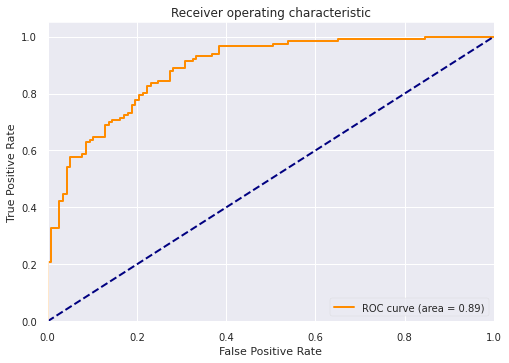

In [18]:
#visualize ROC for validation data
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(test_res['true_label'], test_res['target_preds'])
roc_auc = auc(fpr, tpr)

#plot Reciever Operating Characteristic
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

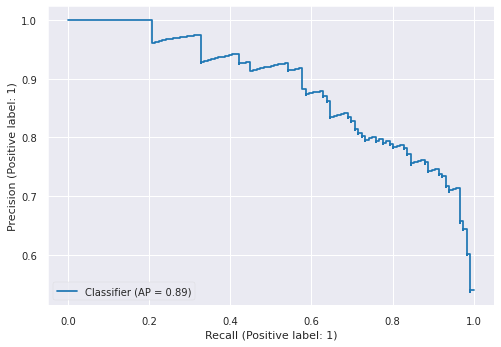

In [19]:
#Generate and Plot Precision Recall Curve
from sklearn.metrics import PrecisionRecallDisplay
ax1 = PrecisionRecallDisplay.from_predictions(test_res['true_label'], test_res['target_preds'])
plt.show()

Validation Set Precision: 0.92
Validation Set Recall: 0.58
Validation Set Accuracy: 0.76
Validation Set Average Precision Score: 0.89
Validation Set Roc Auc Score: 0.89
              precision    recall  f1-score   support

           0       0.69      0.95      0.80       117
           1       0.92      0.58      0.71       116

    accuracy                           0.76       233
   macro avg       0.81      0.76      0.76       233
weighted avg       0.81      0.76      0.76       233



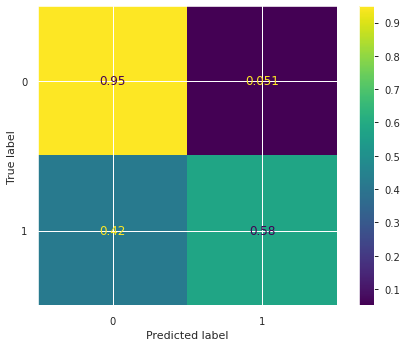

In [20]:
test_set_precision = precision_score(test_res['true_label'], test_res['pred_label'])
test_set_recall = recall_score(test_res['true_label'], test_res['pred_label'])
test_set_accuracy = accuracy_score(test_res['true_label'], test_res['pred_label'])
test_set_average_precision = average_precision_score(test_res['true_label'], test_res['target_preds'])
test_set_auroc = roc_auc_score(test_res['true_label'], test_res['target_preds'])

print(f'Validation Set Precision: {np.round(test_set_precision,2)}')
print(f'Validation Set Recall: {np.round(test_set_recall,2)}')
print(f'Validation Set Accuracy: {np.round(test_set_accuracy,2)}')

print(f'Validation Set Average Precision Score: {np.round(test_set_average_precision,2)}')
print(f'Validation Set Roc Auc Score: {np.round(test_set_auroc,2)}')

print(classification_report(test_res['true_label'], test_res['pred_label']))
    
ConfusionMatrixDisplay.from_predictions(test_res['true_label'], test_res['pred_label'], normalize='true')

### Export best models for future deployment

In [21]:
for fold in range(1,4):
    learn.load(f'resnet34_rocauc_fold{fold}', 
               device=device,     #ensure the loaded model uses the active cuda:0 device
               with_opt=True,     #load optimizer state
               strict=True)
    learn.export(f'/kaggle/working/mel_dect_fold{fold}.pkl')